In [2]:

import sys
sys.path.append("../")
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import transforms as ext_transforms
from models.enet import ENet
from metric.iou import IoU
from args import get_arguments
from data.utils import enet_weighing, median_freq_balancing
import utils
import glob
import cv2
import transforms as ext_transforms

In [3]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
model = ENet(12).to(device) #19 for Cityscapes 11 for Camvid

In [8]:
optimizer = optim.Adam(model.parameters())

In [9]:
model = utils.load_checkpoint(model, optimizer, '../save/ENet_CamVid/','ENet' )[0]

In [10]:
street_images = glob.glob("/10TBdrive/sagarj/Soundscapes_vids/samples/*.jpg")

In [21]:
image_transform = transforms.Compose( [transforms.Resize((480, 640)), transforms.ToTensor()])

In [22]:
model.eval()

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c

In [23]:
cityscapes_color_encoding = OrderedDict([
        ('unlabeled', (0, 0, 0)),
        ('road', (128, 64, 128)),
        ('sidewalk', (244, 35, 232)),
        ('building', (70, 70, 70)),
        ('wall', (102, 102, 156)),
        ('fence', (190, 153, 153)),
        ('pole', (153, 153, 153)),
        ('traffic_light', (250, 170, 30)),
        ('traffic_sign', (220, 220, 0)),
        ('vegetation', (107, 142, 35)),
        ('terrain', (152, 251, 152)),
        ('sky', (70, 130, 180)),
        ('person', (220, 20, 60)),
        ('rider', (255, 0, 0)),
        ('car', (0, 0, 142)),
        ('truck', (0, 0, 70)),
        ('bus', (0, 60, 100)),
        ('train', (0, 80, 100)),
        ('motorcycle', (0, 0, 230)),
        ('bicycle', (119, 11, 32))
])

camvid_color_encoding = OrderedDict([
    ('sky', (128, 128, 128)),
    ('building', (128, 0, 0)),
    ('pole', (192, 192, 128)),
    ('road_marking', (255, 69, 0)),
    ('road', (128, 64, 128)),
    ('pavement', (60, 40, 222)),
    ('tree', (128, 128, 0)),
    ('sign_symbol', (192, 128, 128)),
    ('fence', (64, 64, 128)),
    ('car', (64, 0, 128)),
    ('pedestrian', (64, 64, 0)),
    ('bicyclist', (0, 128, 192)),
    ('unlabeled', (0, 0, 0))
])

In [63]:
image = street_images[100]
image = 'test.png'

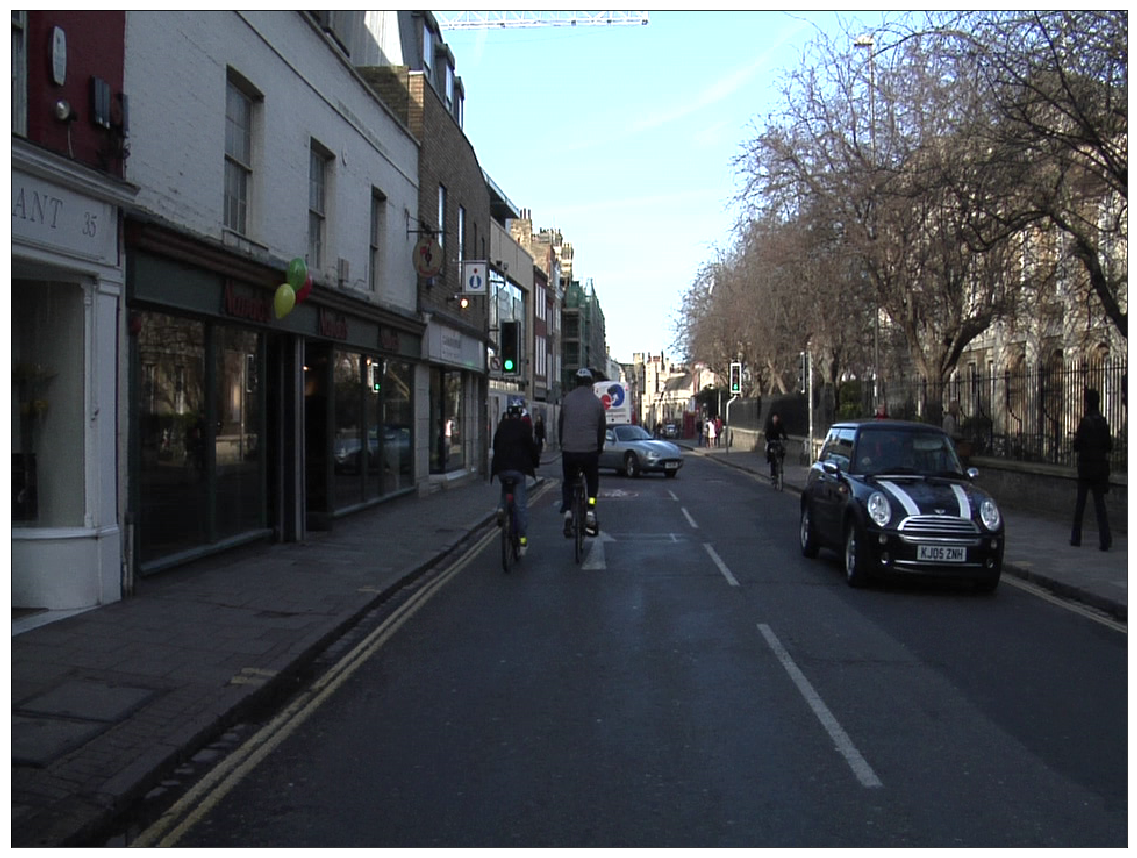

In [64]:

img = Image.open(image)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,30))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [65]:
img = image_transform(img).unsqueeze(0).to(device)
pred = model(img)

In [66]:
# Predictions is one-hot encoded with "num_classes" channels.
# Convert it to a single int using the indices where the maximum (1) occurs
_, predictions = torch.max(pred.data, 1)

label_to_rgb = transforms.Compose([
    ext_transforms.LongTensorToRGBPIL(camvid_color_encoding),
    transforms.ToTensor()
])
# color_predictions = utils.batch_transform(predictions.cpu(), label_to_rgb)
# utils.imshow_batch(pred.data.cpu(), color_predictions)

AttributeError: 'list' object has no attribute 'data'

In [ ]:
color_predictions = utils.batch_transform(predictions.cpu(), label_to_rgb)

In [ ]:
color_predictions

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 30))
images = torchvision.utils.make_grid(img.cpu()).numpy()
labels = torchvision.utils.make_grid(color_predictions).numpy()
ax1.imshow(np.transpose(images, (1, 2, 0)))
ax2.imshow(np.transpose(labels, (1, 2, 0)))

plt.show()


In [ ]:
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
import random

In [67]:
device = torch.device('cuda:6') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [68]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

transformations = Compose([ToPILImage(),ToTensor()])

def get_prediction(image, threshold):
#     i = cv2.imread(img_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    img = transformations(img).unsqueeze(0).to(device)
    pred = model(img)

    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
    if len(pred_t) > 0:
        pred_t = pred_t[-1]
        masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
        pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
        masks = masks[:pred_t+1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        return masks, pred_boxes, pred_class
    else:
        return [] , [] , []



def get_frame_prediction(frame, threshold):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
    img = transformations(img).unsqueeze(0).to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class
    

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [69]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=0.1, text_th=3):
    img = cv2.imread(img_path)
    masks, boxes, pred_cls = get_prediction(img, threshold)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

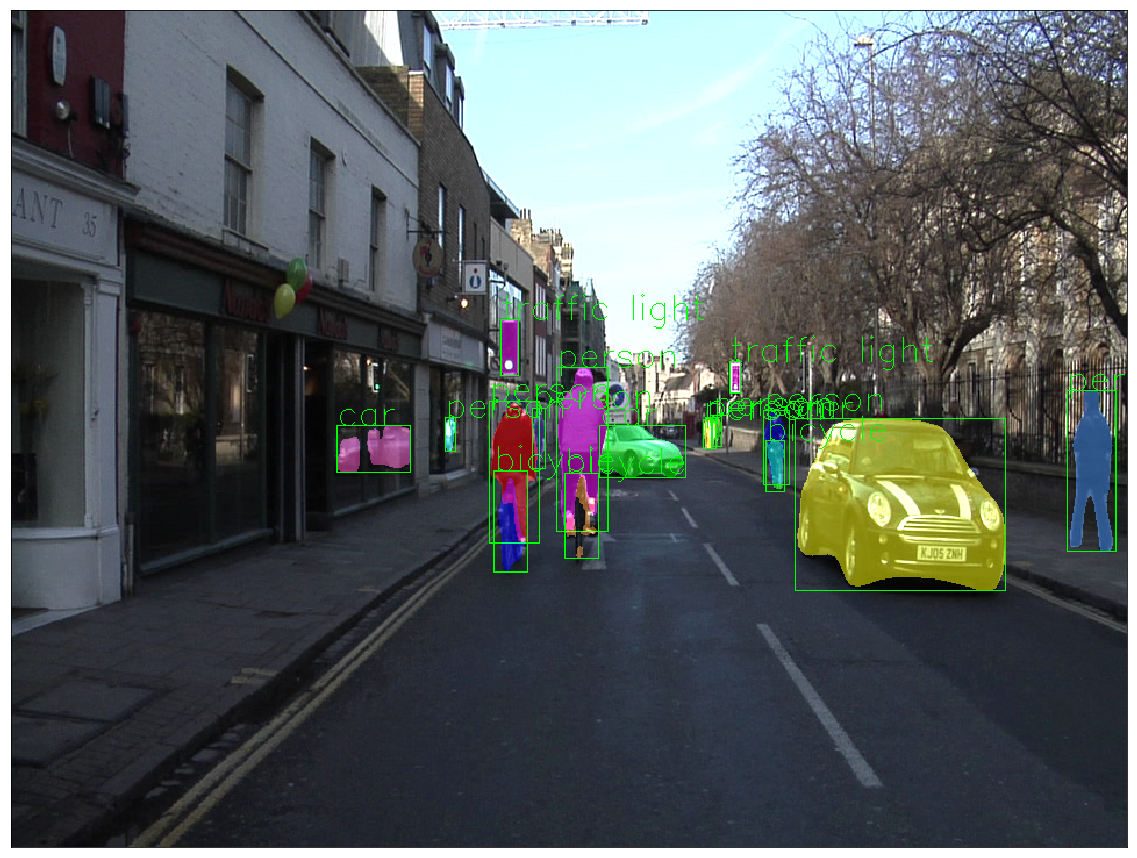

In [70]:
instance_segmentation_api(image,rect_th=1, text_size=1,text_th=1)